In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

In [3]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # comp. domain 
        self.h = 0.1 # dx
        self.k = 0.1 # dt
        x = torch.arange(-1, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)

        # Compute du(x,t)/dx, du(x,t)/dt
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        # Compute du^2(x,t)/dx^2 
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]

        # 1-D Burgers Equation
        # du/dt + u du/dx = \nu du2/dx2
        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx) # LHS = RHS or LHS - RHS = 0-tensor
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [5]:
# training
net = Net()
net.train()

/home/ctutum/anaconda3/envs/PYG/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.1589384377002716
200 0.08977994322776794
300 0.07168666273355484
400 0.04764312505722046
500 0.024485427886247635
600 0.017543092370033264
700 0.01395540963858366
800 0.011417625471949577
900 0.014364137314260006
1000 0.008998398669064045
1100 0.005166788585484028
1200 0.0029740091413259506
1300 0.0021493653766810894
1400 0.0016458623576909304
1500 0.001325580757111311
1600 0.0011023759143427014
1700 0.0009253549505956471
1800 0.0008000261150300503
1900 0.0006164582446217537
2000 0.0005411086021922529
2100 0.00044203471043147147
2200 0.00033424628782086074
2300 0.0003010632935911417
2400 0.0002413530892226845
2500 0.00021323494729585946
2600 0.0002001034445129335
2700 0.00017280582687817514
2800 0.00015007558977231383
2900 0.00013148863217793405
3000 0.00011841651576105505
3100 0.00010159792873309925
3200 9.109645907301456e-05
3300 7.813576667103916e-05
3400 7.145132985897362e-05
3500 6.316429789876565e-05
3600 5.881653487449512e-05
3700 5.677970329998061e-05
3800 5.3836811275687

In [6]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [8]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [9]:
X.shape

torch.Size([20000, 2])

In [10]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [11]:
y_pred.shape

(200, 100)

In [12]:
y_pred

array([[ 0.00230629,  0.00186729,  0.00151896, ..., -0.00206586,
        -0.00205623, -0.00204544],
       [ 0.03399476,  0.03258313,  0.03131313, ...,  0.0056747 ,
         0.00562404,  0.0055757 ],
       [ 0.06551972,  0.06315105,  0.06097355, ...,  0.01341162,
         0.01330123,  0.01319401],
       ...,
       [-0.09744172, -0.09458508, -0.09188591, ..., -0.02513631,
        -0.02489744, -0.02465372],
       [-0.06470431, -0.06283282, -0.06106668, ..., -0.01709624,
        -0.01691743, -0.01673331],
       [-0.03141468, -0.03056692, -0.02976908, ..., -0.0090393 ,
        -0.00892117, -0.00879686]], dtype=float32)

In [13]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

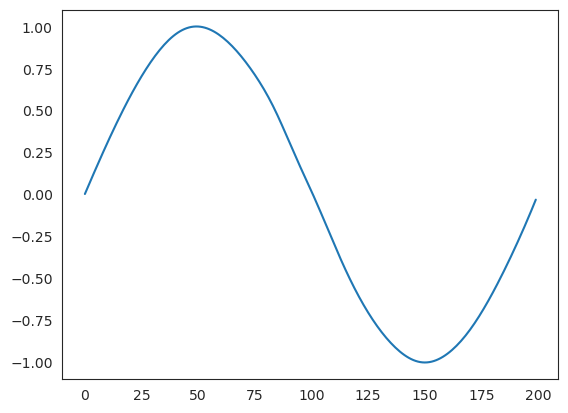

In [14]:
plt.plot(y_pred[:,0])

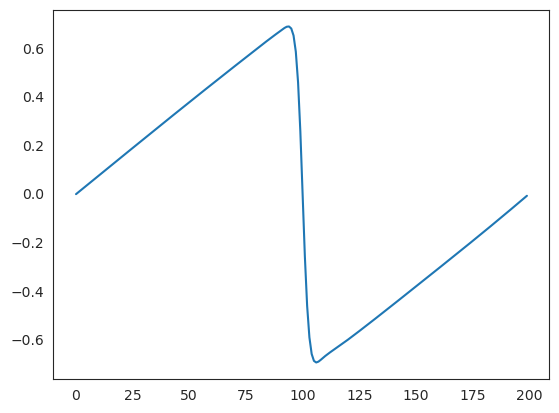

In [15]:
plt.plot(y_pred[:,-1])

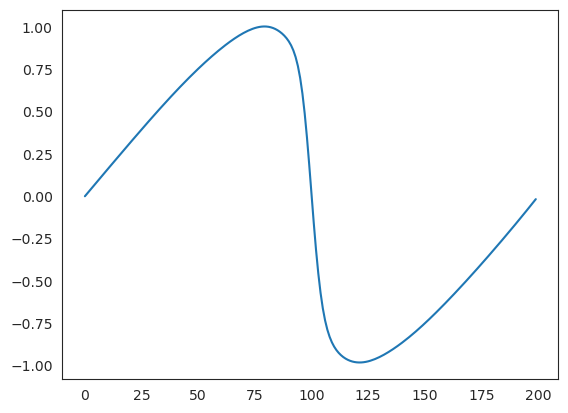

In [16]:
plt.plot(y_pred[:,30])